In [1]:
import pandas as pd

In [2]:
import nltk
from nltk import TweetTokenizer
import string

In [3]:
#import plotting library
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [ ]:
#MERGE query data to event data

In [4]:
df_panama_papers = pd.read_table('data/final/query_panama_papers_data.txt', sep='\t', encoding='utf-8', header=0)
df_offshore = pd.read_table('data/final/query_offshore_data.txt', sep='\t', encoding='utf-8', header=0)
df_leak = pd.read_table('data/final/query_leak_data.txt', sep='\t', encoding='utf-8', header=0)
df_fonseca = pd.read_table('data/final/query_fonseca_data.txt', sep='\t', encoding='utf-8', header=0)
df_tax_haven = pd.read_table('data/final/query_tax_haven_data.txt', sep='\t', encoding='utf-8', header=0)

In [5]:
df_panama_papers['query'] = 'panama papers'
df_offshore['query'] = 'offshore'
df_leak['query'] = 'leak'
df_fonseca['query'] = 'fonseca'
df_tax_haven['query'] = 'tax haven'

In [6]:
df = pd.concat([df_panama_papers, df_offshore, df_leak, df_fonseca, df_tax_haven])
df.shape

(2844241, 21)

In [7]:
#handle event overlap between queries
#not query specific
df = df.drop_duplicates('id_str')
df.shape

(2346998, 21)

In [8]:
#convert date format to python datetime
df['created_at'] = pd.to_datetime(df['created_at'])

In [9]:
#sort data on date posted ascending
df = df.sort_values(by='created_at', ascending=True)

In [10]:
#slice data on event dates
df = df[(df['created_at'] >= '2016-04-02 00:00:00') & (df['created_at'] <= '2016-04-15 00:00:00')]

In [ ]:
#MASTER FILE

In [12]:
df_master = df[['id_str', 'created_at', 'text', 'is_retweet', 'tweet_type']]

In [13]:
df_master['event'] = 'Panama Papers'
df_master['event_description'] = 'A leak of millions of documents detailing global tax evasion named “The Panama Papers”'

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [14]:
df_master = df_master.reset_index()
df_master.columns = ['master_id', 'twitter_id', 'created_at', 'text', 'is_retweet', 'tweet_type', 'event', 'event_description']

In [15]:
#save id, text as master, with index
df_master.to_csv('data/final/event_panama_papers_master.txt', sep='\t', encoding='utf-8', header=True, index=False)

In [16]:
import csv

In [63]:
#save sample for annotation
#no retweets, only text
#sample 1K
smpl = df_master[(df_master['is_retweet'] == False) & (df_master['tweet_type'] == 'text')].sample(1000)
import csv
#format for crowdflower import
#delimited by ;
#double quote strings
smpl.to_csv('data/final/event_panama_papers_master_sample.csv', sep=',', quoting=csv.QUOTE_NONNUMERIC, encoding='utf-8', header=True, index=False)

In [ ]:
#ANALYSIS OF SEARCH

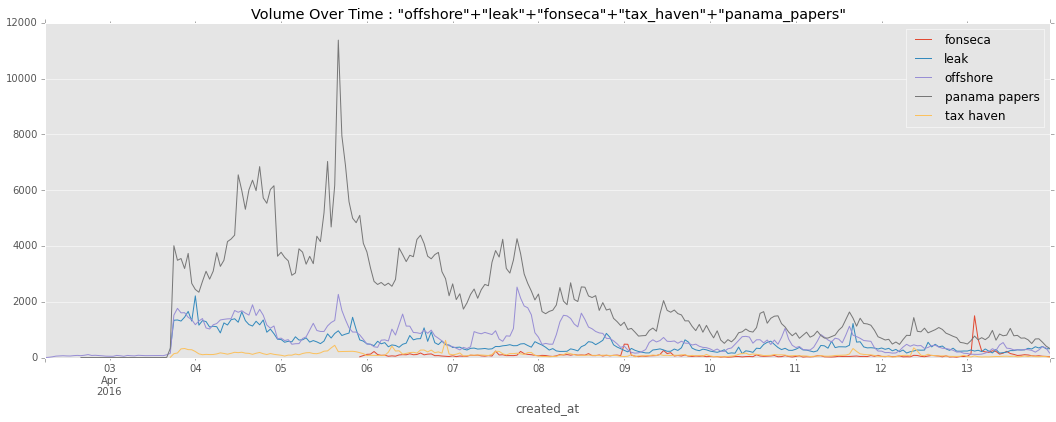

In [26]:
#get tweet counts by query on level hour
d = df[df['is_retweet']==False].set_index('created_at').groupby([pd.TimeGrouper(freq='H'), 'query'])['id_str'].agg(['count'])
#reset index for time series plotting
d = d.reset_index().set_index('created_at')
#plot count by retweet category
ax = d.groupby('query')['count'].plot(#xlim=(pd.Timestamp('2016-04-03'), pd.Timestamp('2016-04-08')),
                                      figsize=(18,6),
                                      legend=True,
                                      title='Volume Over Time : "offshore"+"leak"+"fonseca"+"tax_haven"+"panama_papers"')
#get current figure, save
fig = plt.gcf()
fig.savefig('event_twitter_panama_papers.png')

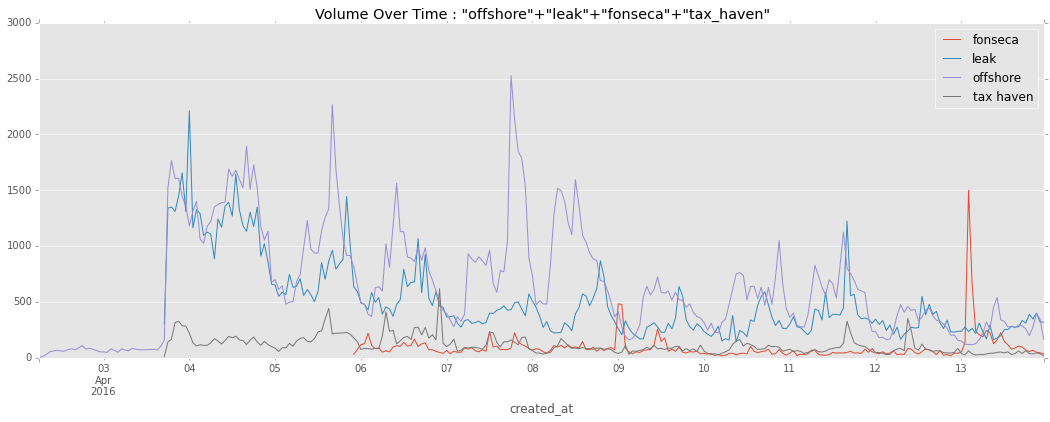

In [27]:
#get tweet counts by query on level hour
d = df[(df['is_retweet']==False) & (df['query'] != 'panama papers')].set_index('created_at').groupby([pd.TimeGrouper(freq='H'), 'query'])['id_str'].agg(['count'])
#reset index for time series plotting
d = d.reset_index().set_index('created_at')
#plot count by retweet category
fig = plt.figure()
ax = d.groupby('query')['count'].plot(#xlim=(pd.Timestamp('2016-04-03'), pd.Timestamp('2016-04-08')),
                                      figsize=(18,6),
                                      legend=True,
                                      title='Volume Over Time : "offshore"+"leak"+"fonseca"+"tax_haven"')
#get current figure, save
fig = plt.gcf()
fig.savefig('event_twitter_panama_papers_minppquery.png')

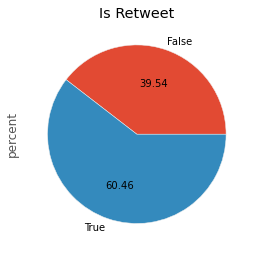

In [31]:
#How many retweets v non?
d = df.groupby('is_retweet')['id_str'].agg(['count'])
d['percent'] = d['count']/df.shape[0]
#d['percent'].plot(kind='bar', ylim=[0,1])
d['percent'].plot(kind='pie',
                  figsize=[4,4],
                  autopct='%.2f',
                  title='Is Retweet')
#get current figure, save
fig = plt.gcf()
fig.savefig('event_panama_papers_retweettype.png')

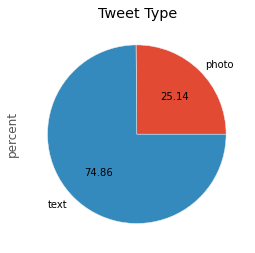

In [30]:
#How many text v media?
d = df.groupby('tweet_type')['id_str'].agg(['count'])
d['percent'] = d['count']/df.shape[0]
d['percent'].plot(kind='pie',
                  figsize=[4,4],
                  autopct='%.2f',
                  title='Tweet Type')#get current figure, save
#get current figure, save
fig = plt.gcf()
fig.savefig('event_panama_papers_tweettype.png')

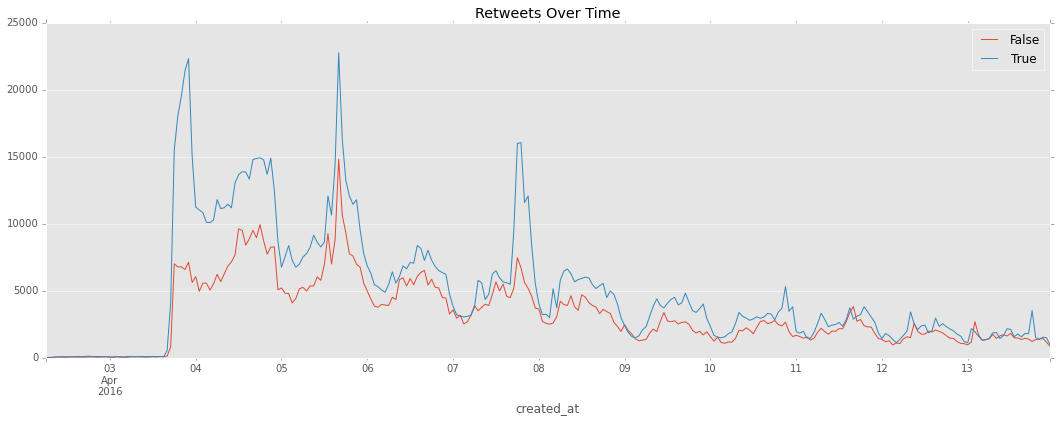

In [32]:
#get tweet counts by retweet category on level hour
d = df.set_index('created_at').groupby([pd.TimeGrouper(freq='H'), 'is_retweet'])['id_str'].agg(['count'])
#reset index for time series plotting
d = d.reset_index().set_index('created_at')
#plot count by retweet category
d.groupby('is_retweet')['count'].plot(figsize=(18,6),
                                      legend=True,
                                      title='Retweets Over Time')
#get current figure, save
fig = plt.gcf()
fig.savefig('event_panama_papers_retweets.png')

In [14]:
#CLEAN TEXT

In [33]:
#remove links
df['text_clean'] = df['text'].apply(lambda text: ' '.join([(w[:w.find('http')] if 'http' in w else w) for w in text.split()]))

#remove hashtags
#only remove symbol
df['text_clean'] = df['text_clean'].apply(lambda text: text.replace('#', ''))
#remove entire token
#df['text_clean'] = df['text_clean'].apply(lambda text: ' '.join([w for w in text.split() if not w.startswith('#')]))

#remove mentions
#only remove symbol
df['text_clean'] = df['text_clean'].apply(lambda text: text.replace('@', ''))
#remove entire token
#df['text_clean'] = df['text_clean'].apply(lambda text: ' '.join([w for w in text.split() if not w.startswith('@')]))

#tokenize, remove stopwords
#method preserves mentions and hashtags
tknzr = TweetTokenizer()
#create stop word list
stop = nltk.corpus.stopwords.words('english')
#add punctuation to stop word list
punct = list(string.punctuation)
#add custom twitter stop words (and "the")
punct.extend(['...', '..', '…', '”', '“', 'the', '.@', 'rt'])
stop.extend(punct)
#apply tokenization, stopword removal
df['text_clean'] = df['text_clean'].apply(lambda s: ' '.join([w.lower() for w in tknzr.tokenize(str(s)) if w.lower() not in stop and len(w) > 2]))

In [ ]:
#SAVE/IMPORT EVENT DATA

In [4]:
#write
#df.to_csv('data/final/event_panama_papers_data.txt', sep='\t', encoding='utf-8', header=True, index=False)
#read
df = pd.read_table('data/final/event_panama_papers_data.txt', sep='\t', encoding='utf-8', header=0)
df.shape

(2297622, 22)

In [5]:
df[df['is_retweet'] == False].shape

(908541, 22)

In [6]:
#fill missing text data for text mining
#df[df['text_clean'].isnull()].shape
df['text_clean'] = df['text_clean'].fillna('')

In [7]:
#convert date format to python datetime
df['created_at'] = pd.to_datetime(df['created_at'])

In [ ]:
#TEXT MINING

In [40]:
#compress series of texts to list
tweets = [ str(d) for d in df[df['is_retweet'] == False]['text_clean']]

In [41]:
#extract tokens
tokens = [ w for t in tweets for w in t.split()]

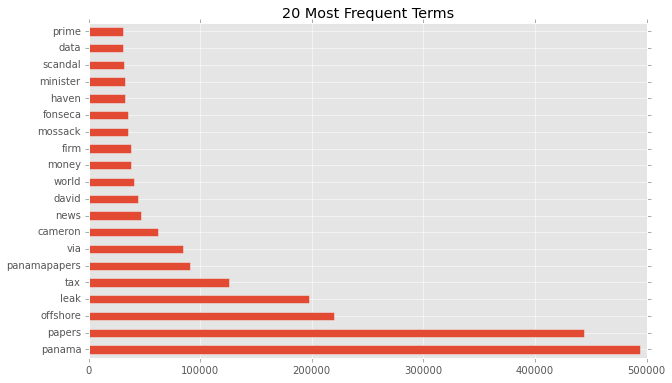

In [43]:
#plot top 20 words
pd.DataFrame(tokens, columns=['tokens'])['tokens'].value_counts()[:20].plot(kind='barh',
                                                                            figsize=(10,6),
                                                                            title='20 Most Frequent Terms')
#get current figure, save
fig = plt.gcf()
fig.savefig('event_panama_papers_top20terms.png')

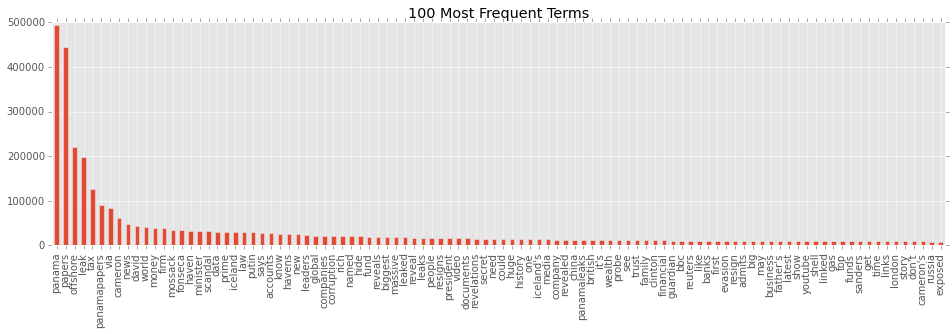

In [62]:
#plot top 100 words
pd.DataFrame(tokens, columns=['tokens'])['tokens'].value_counts()[:100].plot(kind='bar',
                                                                            figsize=(16,4),
                                                                            title='100 Most Frequent Terms')
#get current figure, save
fig = plt.gcf()
fig.savefig('event_panama_papers_top100terms.png')

In [ ]:
#Alt. method for counting
#create counter for topic terms analysis

In [42]:
from collections import Counter

In [44]:
for w in [tokens]:
    termcounts = Counter(w)
    
termcounts.most_common(20)

[('panama', 493817),
 ('papers', 443898),
 ('offshore', 219712),
 ('leak', 197897),
 ('tax', 126112),
 ('panamapapers', 90657),
 ('via', 84926),
 ('cameron', 62067),
 ('news', 47048),
 ('david', 43873),
 ('world', 40844),
 ('money', 38136),
 ('firm', 37964),
 ('mossack', 35352),
 ('fonseca', 34924),
 ('haven', 32868),
 ('minister', 32854),
 ('scandal', 31739),
 ('data', 30939),
 ('prime', 30688)]

In [ ]:
#TOPIC MODELING

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [9]:
#initialize sklearn vectorizer
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=20, max_features=1000, stop_words='english')
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=20, max_features=1000, stop_words='english')

In [10]:
#create matrix of tfidf counts
Xtf = tf_vectorizer.fit_transform(df[df['is_retweet'] == False]['text_clean'])
Xtfidf = tfidf_vectorizer.fit_transform(df[df['is_retweet'] == False]['text_clean'])

In [20]:
#explore sparse matrix
print('TF matrix')
print('sparse matrix shape:', Xtf.shape)
print('size:', (Xtf.shape[0] * Xtf.shape[1]))
print('non-zeros:', Xtf.getnnz())
print('sparsity: %.2f%%' % (100.0 * (((Xtf.shape[0] * Xtf.shape[1]) - Xtf.getnnz()) / (Xtf.shape[0] * Xtf.shape[1]))))
print('density: %.2f%%' % (100.0 * Xtf.getnnz() / (Xtf.shape[0] * Xtf.shape[1])))

TF matrix
sparse matrix shape: (908541, 1000)
size: 908541000
non-zeros: 5485428
sparsity: 99.40%
density: 0.60%


In [21]:
#explore sparse matrix
print('TF-IDF matrix')
print('sparse matrix shape:', Xtfidf.shape)
print('size:', (Xtfidf.shape[0] * Xtfidf.shape[1]))
print('non-zeros:', Xtfidf.getnnz())
print('sparsity: %.2f%%' % (100.0 * (((Xtfidf.shape[0] * Xtfidf.shape[1]) - Xtfidf.getnnz()) / (Xtfidf.shape[0] * Xtfidf.shape[1]))))
print('density: %.2f%%' % (100.0 * Xtfidf.getnnz() / (Xtfidf.shape[0] * Xtfidf.shape[1])))

TF-IDF matrix
sparse matrix shape: (908541, 1000)
size: 908541000
non-zeros: 5485428
sparsity: 99.40%
density: 0.60%


In [17]:
#get vocabulary for both models (should be same, 1000 terms)
Xtfidf_feature_names = tfidf_vectorizer.get_feature_names()
Xtf_feature_names = tf_vectorizer.get_feature_names()

In [70]:
#define universal topic printing function
n_topics = 10
n_top_words = 10

#use model, term vocab, and n terms per topic
def print_top_words(model, feature_names, n_top_words):
    #loop through model output sparse matrix
    #get topic index (rows), terms (cols)
    for topic_idx, topic in enumerate(model.components_):
        #print topic index, list of top n terms
        print("Topic %s:" % topic_idx, " ".join([feature_names[i]+"["+str(termcounts.get(feature_names[i]))+"]" for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [24]:
from time import time

In [ ]:
#RUN Models, Analyze Results

In [25]:
#fit the NMF model to doc tfidf matrix
nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5)
t0 = time()
nmf.fit(Xtfidf)
print("done in %0.3fs" % (time() - t0))

done in 88.539s


In [71]:
print("Topics in NMF model using tfidf:")
print_top_words(nmf, Xtfidf_feature_names, n_top_words)

Topics in NMF model using tfidf:
Topic 0: papers[443898] panama[493817] news[47048] scandal[31739] putin[28986] named[20083] china[12509] reveal[16598] americans[6505] clinton[11099]
Topic 1: offshore[219712] accounts[26868] companies[21706] account[7495] funds[9614] company[12901] replacemovienamewithoffshore[1714] putin[28986] victims[2711] wealth[12045]
Topic 2: leak[197897] data[30939] biggest[18717] history[13878] gas[9666] reveals[18809] massive[18189] new[24879] huge[13986] guide[4476]
Topic 3: tax[126112] haven[32868] havens[25418] evasion[10359] elite[6627] reveals[18809] avoidance[6436] probes[6278] huge[13986] global[22189]
Topic 4: iceland[30270] minister[32854] prime[30688] resigns[16115] scandal[31739] revelations[15335] resign[10294] icelandic[6340] amid[8683] interview[4122]
Topic 5: panamapapers[90657] panamaleaks[12401] corruption[21044] companies[21706] global[22189] linked[9682] revelations[15335] internet[2769] power[5710] breaks[2259]
Topic 6: fonseca[34924] mossa

In [155]:
nmf_t0 = pd.DataFrame(nmf.components_[0], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
nmf_t1 = pd.DataFrame(nmf.components_[1], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
nmf_t2 = pd.DataFrame(nmf.components_[2], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
nmf_t3 = pd.DataFrame(nmf.components_[3], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
nmf_t4 = pd.DataFrame(nmf.components_[4], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
nmf_t5 = pd.DataFrame(nmf.components_[5], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
nmf_t6 = pd.DataFrame(nmf.components_[6], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
nmf_t7 = pd.DataFrame(nmf.components_[7], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]

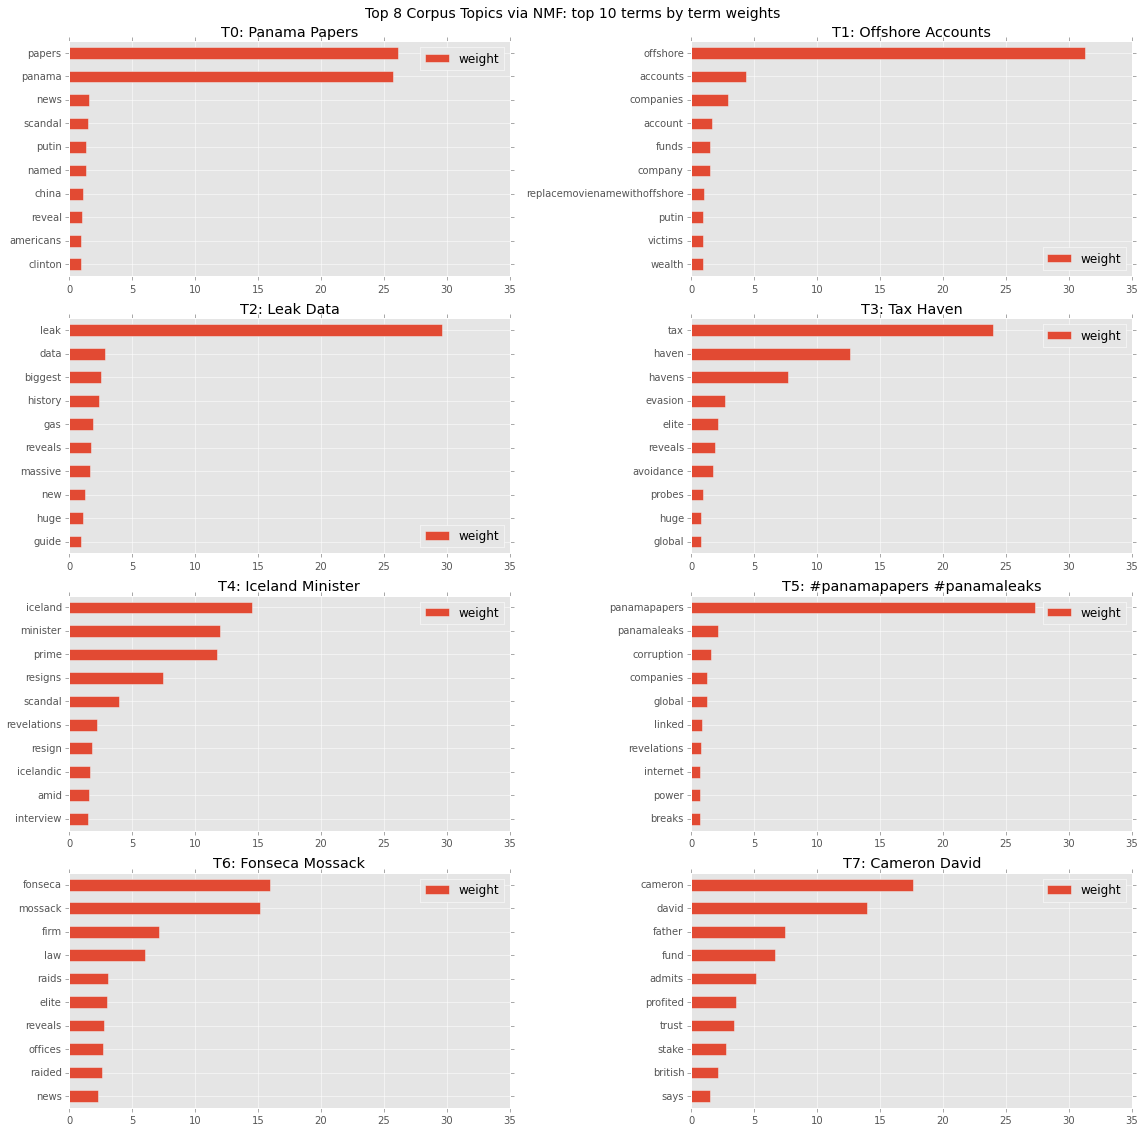

In [386]:
#plot each topic, top 10 terms
#custom names are derived from top 2 weighted terms per topic
fig = plt.figure(figsize=(16, 16))
fig.suptitle('Top 8 Corpus Topics via NMF: top 10 terms by term weights ', fontsize=14)
plt.subplot(4,2,1)
nmf_t0.plot(ax=plt.gca(), kind='barh', xlim=[0,35], legend=True, title='T0: Panama Papers')
plt.subplot(4,2,2)
nmf_t1.plot(ax=plt.gca(), kind='barh', xlim=[0,35], legend=True, title='T1: Offshore Accounts')
plt.subplot(4,2,3)
nmf_t2.plot(ax=plt.gca(), kind='barh', xlim=[0,35], legend=True, title='T2: Leak Data')
plt.subplot(4,2,4)
nmf_t3.plot(ax=plt.gca(), kind='barh', xlim=[0,35], legend=True, title='T3: Tax Haven')
plt.subplot(4,2,5)
nmf_t4.plot(ax=plt.gca(), kind='barh', xlim=[0,35], legend=True, title='T4: Iceland Minister')
plt.subplot(4,2,6)
nmf_t5.plot(ax=plt.gca(), kind='barh', xlim=[0,35], legend=True, title='T5: #panamapapers #panamaleaks')
plt.subplot(4,2,7)
nmf_t6.plot(ax=plt.gca(), kind='barh', xlim=[0,35], legend=True, title='T6: Fonseca Mossack')
plt.subplot(4,2,8)
nmf_t7.plot(ax=plt.gca(), kind='barh', xlim=[0,35], legend=True, title='T7: Cameron David')

#get current figure, save
fig = plt.gcf()
fig.tight_layout()
fig.subplots_adjust(top=.95)
fig.savefig('event_panama_papers_topicmod_NMFtop8.png')

In [27]:
#fit the lda model to doc tf matrix
#topic per document distribution, default alpha = 1/n
#term per document distribution, default beta = 1/n
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0)
t0 = time()
lda.fit(Xtf)
print("done in %0.3fs" % (time() - t0))

done in 432.617s


In [157]:
print("Topics in LDA model using tf:")
print_top_words(lda, Xtf_feature_names, n_top_words)

Topics in LDA model using tf:
Topic 0: panama[493817] papers[443898] cameron[62067] david[43873] offshore[219712] know[25577] accounts[26868] video[15632] father[7762] reuters[10922]
Topic 1: tax[126112] offshore[219712] hide[20079] havens[25418] trust[11445] don[None] office[5501] week[5624] evasion[10359] taxes[7155]
Topic 2: minister[32854] fund[18834] prime[30688] offices[7232] iceland[30270] offshore[219712] raid[6634] like[10920] revelations[15335] finance[5346]
Topic 3: money[38136] offshore[219712] people[16533] clinton[11099] authorities[6756] details[4749] hillary[6121] want[5273] keystone[4576] end[4232]
Topic 4: panama[493817] papers[443898] fonseca[34924] mossack[35352] leak[197897] reveal[16598] leaked[18086] corruption[21044] cia[3418] banks[10727]
Topic 5: putin[28986] offshore[219712] use[6980] secret[15238] guardian[10944] used[7345] russia[8773] revealed[12798] public[6968] report[6344]
Topic 6: firm[37964] law[29082] says[27679] offshore[219712] british[12282] londo

In [154]:
#get top 10 terms per topic
lda_t0 = pd.DataFrame(lda.components_[0], index=Xtf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
lda_t1 = pd.DataFrame(lda.components_[1], index=Xtf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
lda_t2 = pd.DataFrame(lda.components_[2], index=Xtf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
lda_t3 = pd.DataFrame(lda.components_[3], index=Xtf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
lda_t4 = pd.DataFrame(lda.components_[4], index=Xtf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
lda_t5 = pd.DataFrame(lda.components_[5], index=Xtf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
lda_t6 = pd.DataFrame(lda.components_[6], index=Xtf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
lda_t7 = pd.DataFrame(lda.components_[7], index=Xtf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
lda_t8 = pd.DataFrame(lda.components_[8], index=Xtf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
lda_t9 = pd.DataFrame(lda.components_[9], index=Xtf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]

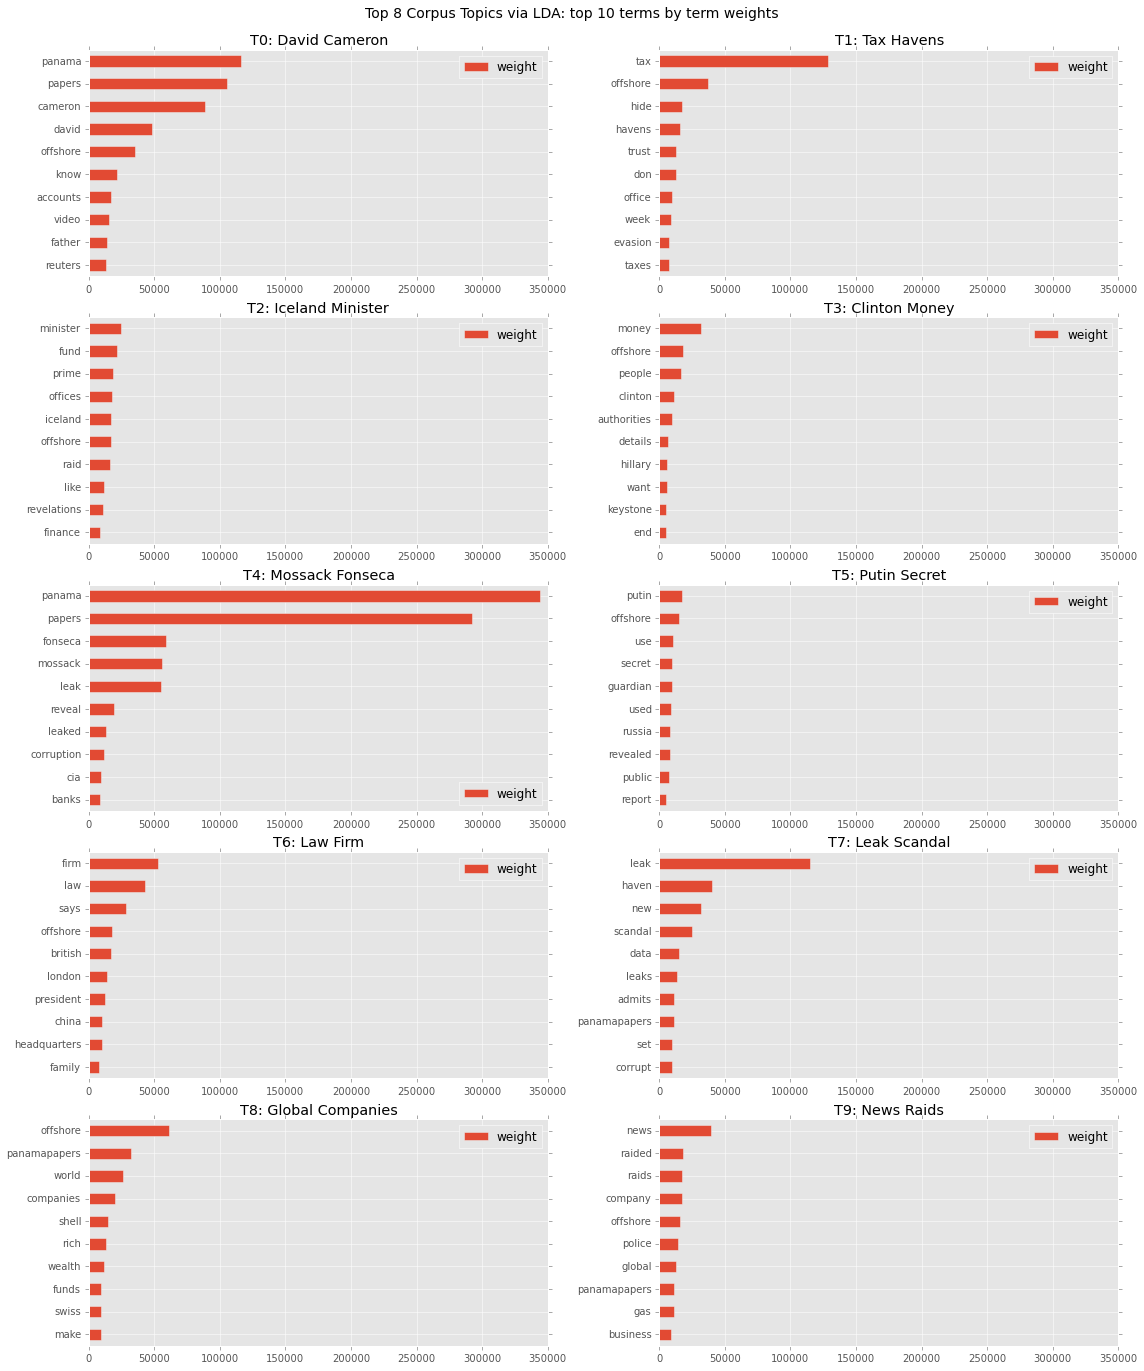

In [384]:
#plot each topic, top 10 terms
#custom topic names are derived intuitively from the data
fig = plt.figure(figsize=(16, 20))
fig.suptitle('Top 8 Corpus Topics via LDA: top 10 terms by term weights ', fontsize=14)
plt.subplot(5,2,1)
lda_t0.plot(ax=plt.gca(), kind='barh', xlim=[0,350000], legend=True, title='T0: David Cameron')
plt.subplot(5,2,2)
lda_t1.plot(ax=plt.gca(), kind='barh', xlim=[0,350000], legend=True, title='T1: Tax Havens')
plt.subplot(5,2,3)
lda_t2.plot(ax=plt.gca(), kind='barh', xlim=[0,350000], legend=True, title='T2: Iceland Minister')
plt.subplot(5,2,4)
lda_t3.plot(ax=plt.gca(), kind='barh', xlim=[0,350000], legend=True, title='T3: Clinton Money')
plt.subplot(5,2,5)
lda_t4.plot(ax=plt.gca(), kind='barh', xlim=[0,350000], legend=True, title='T4: Mossack Fonseca')
plt.subplot(5,2,6)
lda_t5.plot(ax=plt.gca(), kind='barh', xlim=[0,350000], legend=True, title='T5: Putin Secret')
plt.subplot(5,2,7)
lda_t6.plot(ax=plt.gca(), kind='barh', xlim=[0,350000], legend=True, title='T6: Law Firm')
plt.subplot(5,2,8)
lda_t7.plot(ax=plt.gca(), kind='barh', xlim=[0,350000], legend=True, title='T7: Leak Scandal')
plt.subplot(5,2,9)
lda_t8.plot(ax=plt.gca(), kind='barh', xlim=[0,350000], legend=True, title='T8: Global Companies')
plt.subplot(5,2,10)
lda_t9.plot(ax=plt.gca(), kind='barh', xlim=[0,350000], legend=True, title='T9: News Raids')

#get current figure, save
fig = plt.gcf()
fig.tight_layout()
fig.subplots_adjust(top=.95)
fig.savefig('event_panama_papers_topicmod_LDAtop10.png')

In [ ]:
#LDA-Specific Document-Topic Analysis

In [170]:
#compute matrix of documents per topic
lda_dtX = lda.transform(Xtf)

In [286]:
#get max topic for each document
#agg on axis 1 = rows
df_ldatopics = pd.DataFrame(lda_dtX.argmax(axis=1), columns=['topic'])

In [287]:
#join doc topics to doc dates
#join on axis 1 = index
df_ldatopics = pd.concat([df_ldatopics, df[df['is_retweet'] == False].reset_index()[['created_at', 'id_str']]], axis=1)

In [288]:
#create map from topic index to names
lda_t8indexes = [0,1,2,3,4,5,6,7,8,9]
lda_t8names = ['David Cameron', 'Tax Havens', 'Iceland Minister', 'Clinton Money', 'Mossack Fonseca', 'Putin Secret', 'Law Firm', 'Leak Scandal', 'Global Companies', 'News Raids']

In [289]:
#replace topic index with name
df_ldatopics['topic'] = df_ldatopics['topic'].replace(lda_t8indexes, lda_t8names)

In [87]:
#LDA topic-document distribution
lda_tcounts = df_ldatopics.groupby('topic')['id_str'].agg(['count'])
lda_tcounts.plot(kind='bar',
                 figsize=(6,6),
                 title='Topic-Document Distribution')
#get current figure, save
fig = plt.gcf()
fig.tight_layout()
fig.savefig('event_panama_papers_topicmod_LDAtop10_dist.png')

NameError: name 'df_ldatopics' is not defined

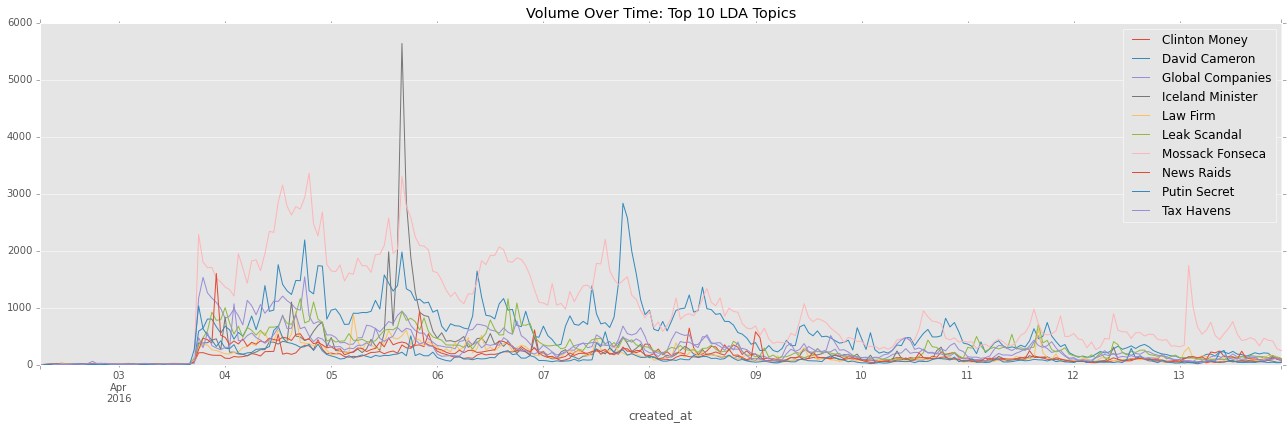

In [372]:
#plot document topics over time
d = df_ldatopics.set_index('created_at').groupby([pd.TimeGrouper(freq='H'), 'topic'])['id_str'].agg(['count'])
#reset index for time series plotting
d = d.reset_index().set_index('created_at')
#plot count by retweet category
fig = plt.figure()
ax = d.groupby('topic')['count'].plot(figsize=(18,6),
                                      legend=True,
                                      title='Volume Over Time: Top 10 LDA Topics')
#get current figure, save
fig = plt.gcf()
fig.tight_layout()
fig.savefig('event_panama_papers_topicmod_LDAtop10_overtime.png')

In [391]:
#CLUSTERING

In [ ]:
#K-MEANS

In [11]:
from sklearn.cluster import KMeans

In [12]:
cluster_num = 8

In [13]:
km = KMeans(n_clusters=cluster_num)

In [14]:
%%time
km.fit(Xtfidf)

Wall time: 10min 58s


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [ ]:
#print out top terms per cluster (redundant to below plot)
#matrix of sorted terms per cluster
#ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]
#for c in range(cluster_num):
#    print('Cluster:', c),
#    for i in ordered_centroids[c, :10]:
#        print('  ', Xtfidf_feature_names[i])
#    print()

In [ ]:
#get top 10 terms per cluster
km_c0 = pd.DataFrame(km.cluster_centers_[0], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
km_c1 = pd.DataFrame(km.cluster_centers_[1], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
km_c2 = pd.DataFrame(km.cluster_centers_[2], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
km_c3 = pd.DataFrame(km.cluster_centers_[3], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
km_c4 = pd.DataFrame(km.cluster_centers_[4], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
km_c5 = pd.DataFrame(km.cluster_centers_[5], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
km_c6 = pd.DataFrame(km.cluster_centers_[6], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]
km_c7 = pd.DataFrame(km.cluster_centers_[7], index=Xtfidf_feature_names, columns=['weight']).sort_values(by='weight', ascending=True)[-10:]

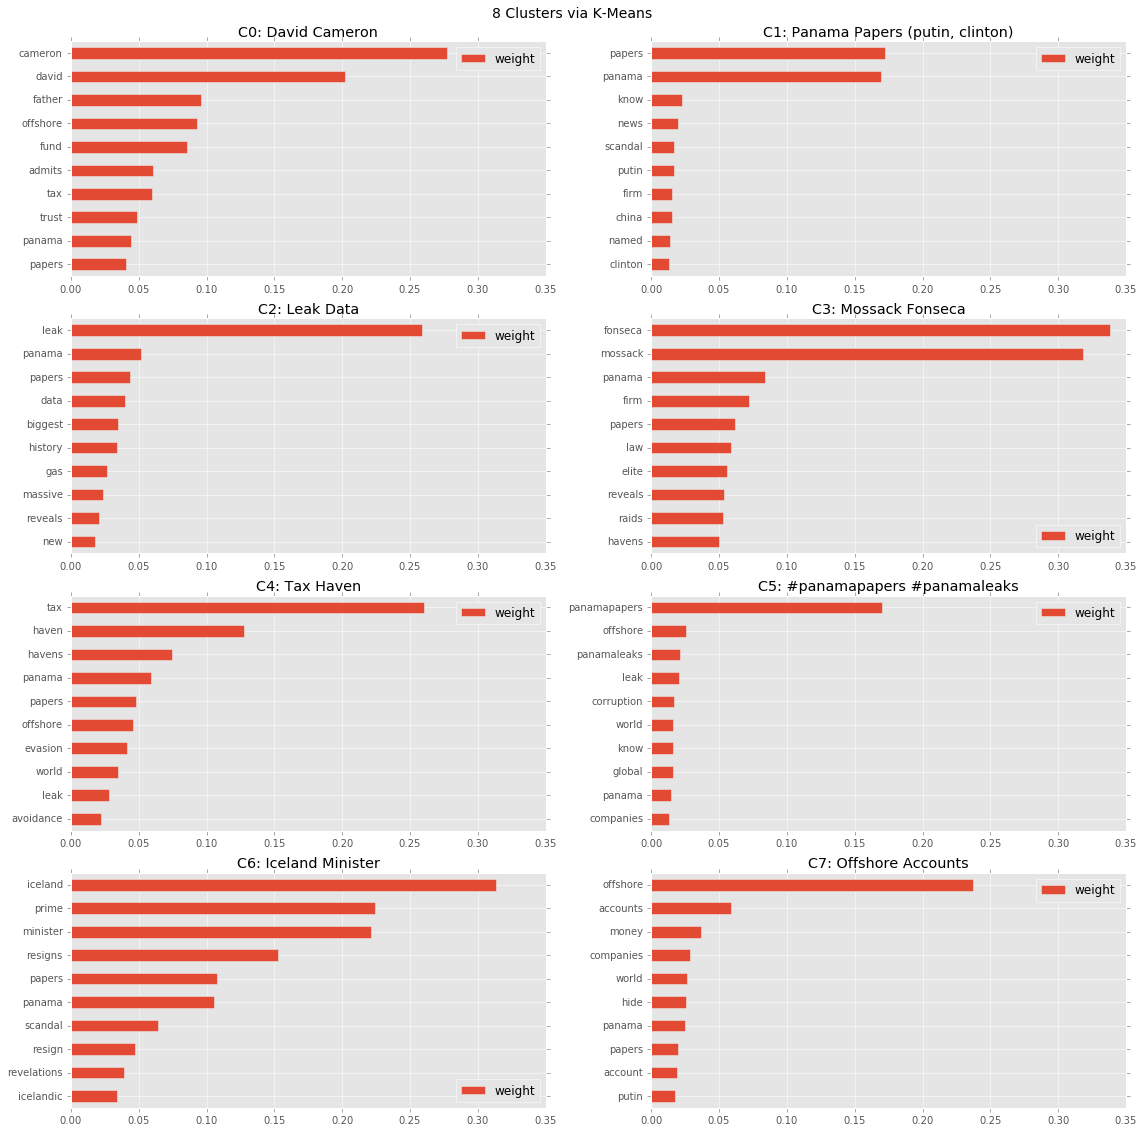

In [110]:
#plot each topic, top 10 terms
#custom names are derived from top 2 weighted terms per topic
fig = plt.figure(figsize=(16, 16))
fig.suptitle('8 Clusters via K-Means', fontsize=14)
plt.subplot(4,2,1)
km_c0.plot(ax=plt.gca(), kind='barh', xlim=[0,.35], legend=True, title='C0: David Cameron')
plt.subplot(4,2,2)
km_c1.plot(ax=plt.gca(), kind='barh', xlim=[0,.35], legend=True, title='C1: Panama Papers (putin, clinton)')
plt.subplot(4,2,3)
km_c2.plot(ax=plt.gca(), kind='barh', xlim=[0,.35], legend=True, title='C2: Leak Data')
plt.subplot(4,2,4)
km_c3.plot(ax=plt.gca(), kind='barh', xlim=[0,.35], legend=True, title='C3: Mossack Fonseca')
plt.subplot(4,2,5)
km_c4.plot(ax=plt.gca(), kind='barh', xlim=[0,.35], legend=True, title='C4: Tax Haven')
plt.subplot(4,2,6)
km_c5.plot(ax=plt.gca(), kind='barh', xlim=[0,.35], legend=True, title='C5: #panamapapers #panamaleaks')
plt.subplot(4,2,7)
km_c6.plot(ax=plt.gca(), kind='barh', xlim=[0,.35], legend=True, title='C6: Iceland Minister')
plt.subplot(4,2,8)
km_c7.plot(ax=plt.gca(), kind='barh', xlim=[0,.35], legend=True, title='C7: Offshore Accounts')

#get current figure, save
fig = plt.gcf()
fig.tight_layout()
fig.subplots_adjust(top=.95)
#fig.savefig('event_panama_papers_topicmod_NMFtop8.png')

In [111]:
#get clusters per doc
df_kmclust = pd.DataFrame(km.labels_, columns=['cluster'])

In [112]:
#join doc topics to doc dates
#join on axis 1 = index
df_kmclust = pd.concat([df_kmclust, df[df['is_retweet'] == False].reset_index()[['created_at', 'id_str']]], axis=1)

In [113]:
#create map from topic index to names
km_c8indexes = [0,1,2,3,4,5,6,7]
km_c8names = ['David Cameron', 'Panama Papers', 'Leak Data', 'Mossack Fonseca', 'Tax Haven', '#panamapapers #panamaleaks', 'Iceland Minister', 'Offshore Accounts']

In [114]:
#replace topic index with name
df_kmclust['cluster'] = df_kmclust['cluster'].replace(km_c8indexes, km_c8names)

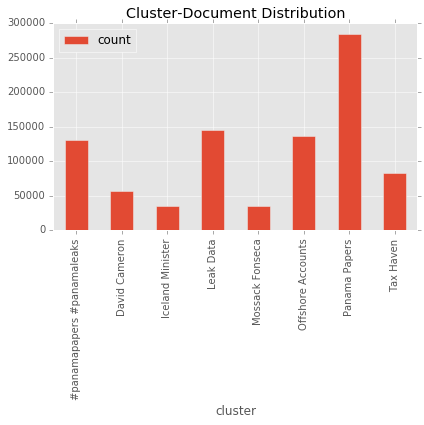

In [116]:
#Kmeans cluster-document distribution
km_ccounts = df_kmclust.groupby('cluster')['id_str'].agg(['count'])
km_ccounts.plot(kind='bar',
                 figsize=(6,6),
                 title='Cluster-Document Distribution')
#get current figure, save
fig = plt.gcf()
fig.tight_layout()
fig.savefig('event_panama_papers_cluster_KMeans8_dist.png')

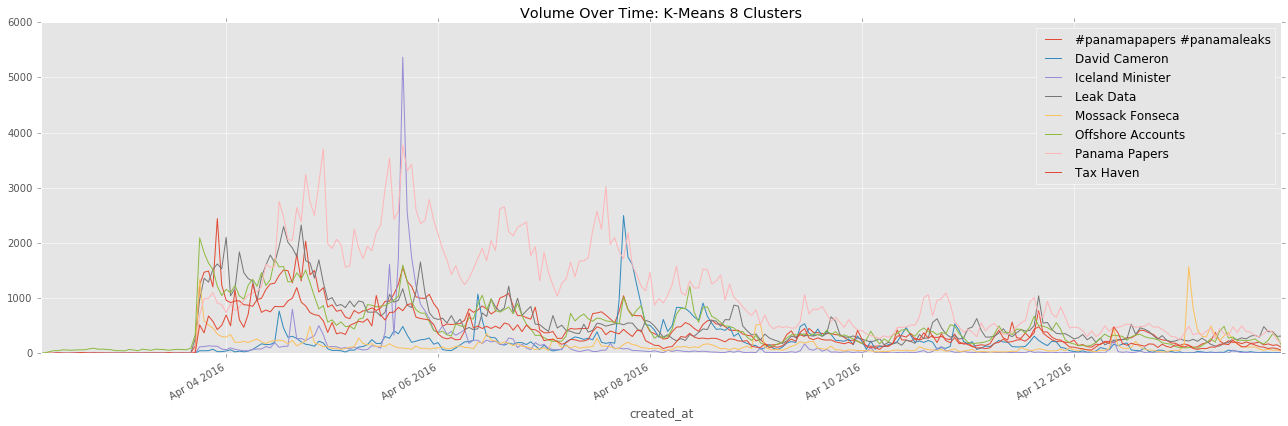

In [117]:
#plot document clusters over time
d = df_kmclust.set_index('created_at').groupby([pd.TimeGrouper(freq='H'), 'cluster'])['id_str'].agg(['count'])
#reset index for time series plotting
d = d.reset_index().set_index('created_at')
#plot count by retweet category
fig = plt.figure()
ax = d.groupby('cluster')['count'].plot(figsize=(18,6),
                                      legend=True,
                                      title='Volume Over Time: K-Means 8 Clusters')
#get current figure, save
fig = plt.gcf()
fig.tight_layout()
fig.savefig('event_panama_papers_cluster_KMeans8_overtime.png')

In [394]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#compute cosine similarity distance matrix
#alternative to single, complete, average, euclidean, manhattan etc.

#dist = 1 - cosine_similarity(Xtfidf)

In [ ]:
from scipy.cluster.hierarchy import ward

In [ ]:
#perform wards linkage on distance matrix
Xlinkage = ward(dist)

In [392]:
from scipy.cluster.hierarchy import linkage

In [ ]:
#generate the linkage matrix
#using ward
#Xlinkage = linkage(X, 'ward')

In [ ]:
#visualize dendrogram tree of hiearchical results, cluster separation

In [ ]:
from scipy.cluster.hierarchy import dendrogram

In [ ]:
fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage_matrix, orientation="right", truncate_mode='lastp', p=50, show_leaf_counts=True, show_contracted=False);